# OBJECTIVE:
Predict the carbon emissions and energy consumption. 

# KEY FEATURES:

*   ***Entity:*** The name of the country or region for which the data is reported (RELEVANT TO THE INVESTIGATION).

*   ***Year:*** The year for which the data is reported, ranging from 2000 to 2020 (RELEVANT TO THE INVESTIGATION).

*   ***Access to electricity (% of population):*** The percentage of population with access to electricity (RELEVANT TO THE ELECTRICITY FORCASTING).

*   ***Access to clean fuels for cooking (% of population):*** The percentage of the population with primary reliance on clean fuels (RELEVANT TO THE INVESTIGATION).

*   ***Renewable-electricity-generating-capacity-per-capita:*** Installed Renewable energy capacity per person

*   ***Financial flows to developing countries (US $):*** Aid and assistance from developed countries for clean energy projects.

*   ***Renewable energy share in total final energy consumption (%):*** Percentage of renewable energy in final energy consumption.

*   ***Electricity from fossil fuels (TWh):*** Electricity generated from fossil fuels (coal, oil, gas) in terawatt-hours.

*   ***Electricity from nuclear (TWh):*** Electricity generated from nuclear power in terawatt-hours.

*   ***Electricity from renewables (TWh):*** Electricity generated from renewable sources (hydro, solar, wind, etc.) in terawatt-hours.

*   ***Low-carbon electricity (% electricity):*** Percentage of electricity from low-carbon sources (nuclear and renewables).

*   ***Primary energy consumption per capita (kWh/person) -- (TARGET):*** Energy consumption per person in kilowatt-hours.

*   ***Energy intensity level of primary energy (MJ/$2011 PPP GDP):*** Energy use per unit of GDP at purchasing power parity.

*   ***Value_co2_emissions (metric tons per capita) -- (TARGET):*** Carbon dioxide emissions per person in metric tons.

*   ***Renewables (% equivalent primary energy):*** Equivalent primary energy that is derived from renewable sources.

*   ***GDP growth (annual %):*** Annual GDP growth rate based on constant local currency.

*   ***GDP per capita:*** Gross domestic product per person.

*   ***Density (P/Km2):*** Population density in persons per square kilometer.

*   ***Land Area (Km2):*** Total land area in square kilometers.

*   ***Latitude:*** Latitude of the country's centroid in decimal degrees.

*   ***Longitude:*** Longitude of the country's centroid in decimal degrees.

##### NOTE: In parentesis and mayus, we have the variable importance for our investigation (2 targets).

In [1]:
# LIBRARIES:
import pandas as pd
import numpy as np

# IMPUTERS:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# SHOWCASTING THE DATA:
pd.set_option("display.max_column", None)

# TIME SERIES MODELS:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

# GRAPHS:
import matplotlib.pyplot as plt

# ENCODERS:
from sklearn.preprocessing import LabelEncoder 

In [2]:
# FUNTIONS:

def NaNs_calculator(data):
    
    '''SHOWING THE STATS OF MISSING DATA AND DATA TYPE'''

    percentage_missing = (data.isna().mean()*100).sort_values(ascending = False)        # Storing the Percentages of NaNs
    sum_missing = data.isna().sum().sort_values(ascending = False)                      # Storing the Sum of NaNs
    names = sum_missing.index.to_list()                                                 # Storing names (to show in the columns)
    data_type = data[names].dtypes                                                      # Storing the type of data based on the order from the previous obtained data (slicing)
    sum_values = sum_missing.to_list()                                                  # Getting count of missing values
    perc_values = np.around(percentage_missing.to_list(), 3)                            # Getting percentage of missing values
    types = data_type.to_list()                                                         # Getting the types of the data
    # TURN ALL THE DATA INTO A DATAFRAME
    df_missing = pd.DataFrame({"NAMES" : names,                                         
                                    "VALUE COUNT" : sum_values,
                                    "PERCENTAGE (%)" : perc_values,
                                    "DATA TYPE": types})
    return df_missing


def drawing(data, energy_country):
    
    """PLOTTING WITH A FOR LOOP"""
    # plt.figure(figsize=(12, 80))
    # plt.subplot(22, 2, 1)
    # drawing(data[0])

    # Iterate over unique countries and plot their time series    
    for country in data:
        plt.plot(energy_country.loc[energy_country['Entity'] == country].index, energy_country.loc[energy_country['Entity'] == country]['TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)'], label=country)
    
    plt.xlabel('Year')
    plt.ylabel('Energy Consumption per country')
    plt.title('Energy Consumption Over Time (2000-2020)')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()


def data_slicing(data, chunk_number):
    """THIS FUNCTION WILL SLICE THE DATA FRAME INTO SMALER PIECES. FOR EXAMPLE, PASSING THE COUNTRIES IN WILL PROVIDE THE LABELS FOR YOUR GRAPHS"""
    
    # EXTRACTING THE CHUCKS
    segment_numbers = int(len(data)/chunk_number)           # for example a chunk_number of 4 will give 4 segments of 44 rows per chunk. 
    sliced_df = []                                          # Stored chunks
    segment = None                                          # to store the slice 

    for chunk in range(0, len(data), segment_numbers):
        segment = data[chunk:chunk + segment_numbers]       # Start index to the end
        sliced_df.append(segment)                           # Storing the segment

    return sliced_df
    

In [3]:
# IMPORTING DATA:
df = pd.read_csv(r"/Users/alberto/Desktop/PROJECTS/ML on Cloud/global-data-on-sustainable-energy.csv", 
                 parse_dates = ['Year'], index_col = 'Year')
df.head()

,Entity,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
Year,,,,,,,,,,,,,,,,,,,,
2000-01-01,Afghanistan,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,65.957440,302.59482,1.64,760.000000,NaN,NaN,NaN,60,"6,52,230",33.93911,67.709953
2001-01-01,Afghanistan,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,84.745766,236.89185,1.74,730.000000,NaN,NaN,NaN,60,"6,52,230",33.93911,67.709953
2002-01-01,Afghanistan,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,81.159424,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,"6,52,230",33.93911,67.709953
2003-01-01,Afghanistan,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,67.021280,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,"6,52,230",33.93911,67.709953
2004-01-01,Afghanistan,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,62.921350,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,"6,52,230",33.93911,67.709953


# FORMATTING DATA:
To avoid error when handling the data in columns,a common format is applied here:

In [4]:
# FORMATTING THE COLUMN NAMES SO IT IS EASIER TO HANDLE THEM (PUTTING THE '_' ON ANY SPACE):
for x in list(df.columns):
    # TESTING STORING AND CHANGING NAMES ACCORDINGLY:
    if(x == "Value_co2_emissions_kt_by_country"):
        name = x.replace("Value_co2_emissions_kt_by_country", "TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY")
        df.rename(columns={x: name}, inplace=True)
    elif(x == "Primary energy consumption per capita (kWh/person)"):
        name = x.replace("Primary energy consumption per capita (kWh/person)", "TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)")
        df.rename(columns={x: name}, inplace=True)
    else:
        if(" " in x):
            name = x.replace(" ", '_')                  
        elif("-" in x):
            name = x.replace("-", '_')                  
        elif("\\n" in x):
            name = x.replace("\\n", '_')
        else:
            name = x                  
        df.rename(columns={x: name.title()}, inplace=True)  # Setting the new name to the column
    name = ''
df.head()

,Entity,Access_To_Electricity_(%_Of_Population),Access_To_Clean_Fuels_For_Cooking,Renewable_Electricity_Generating_Capacity_Per_Capita,Financial_Flows_To_Developing_Countries_(Us_$),Renewable_Energy_Share_In_The_Total_Final_Energy_Consumption_(%),Electricity_From_Fossil_Fuels_(Twh),Electricity_From_Nuclear_(Twh),Electricity_From_Renewables_(Twh),Low-Carbon_Electricity_(%_Electricity),TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON),Energy_Intensity_Level_Of_Primary_Energy_(Mj/$2017_Ppp_Gdp),TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY,Renewables_(%_Equivalent_Primary_Energy),Gdp_Growth,Gdp_Per_Capita,Density_(P/Km2),Land_Area(Km2),Latitude,Longitude
Year,,,,,,,,,,,,,,,,,,,,
2000-01-01,Afghanistan,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,65.957440,302.59482,1.64,760.000000,NaN,NaN,NaN,60,"6,52,230",33.93911,67.709953
2001-01-01,Afghanistan,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,84.745766,236.89185,1.74,730.000000,NaN,NaN,NaN,60,"6,52,230",33.93911,67.709953
2002-01-01,Afghanistan,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,81.159424,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,"6,52,230",33.93911,67.709953
2003-01-01,Afghanistan,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,67.021280,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,"6,52,230",33.93911,67.709953
2004-01-01,Afghanistan,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,62.921350,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,"6,52,230",33.93911,67.709953


In [5]:
# # # Assuming year integers are provided
# # years = df['Year']

# # # Convert year integers to datetime objects
# # datetime_objects = pd.to_datetime(years, format='%Y')

# # print(datetime_objects)

# # # Create a date range with yearly frequency
# # date_range = pd.date_range(start=datetime_objects.min(), end=datetime_objects.max(), freq='YS')

# # # Reindex the DataFrame with the date range
# # df = pd.DataFrame(index=date_range)


# # Assuming year integers are provided
# years = df['Year']

# # Convert year integers to datetime objects
# datetime_objects = pd.to_datetime(df['Year'], format='%Y')

# # Create a date range with yearly frequency
# date_range = pd.date_range(start = datetime_objects.min(), end = datetime_objects.max(), freq='YS')
# print((date_range).unique())
# print((df['Year'].unique()))

# # MATCHING THE NUMBERS INTO A DICTIONARY
# # parsed_date = {2:'El num 2'}
# # print(parsed_date)
# # print(parsed_date[2])

# parsed_date ={} # 1. dict con los valores correspindientes (num: date value)
# for num_year, parsed_year in zip(df['Year'], date_range):
#     # print(f'from num_year = {num_year} into parsed_year = {parsed_year}')
#     parsed_date[num_year] = parsed_year
#     # print(parsed_date[num_year])

# print(len(parsed_date))

# # 2. loopeo sobre la columna year, y cada conicidencia va a ser a crear una nueva variable que vamos a poner dentro del data frame como index

# # Creating a new varible to store the parsed dates:
# dates = []

# for year_in_col in df['Year']:
#     # Creating a new column
#     dates.append(parsed_date[year_in_col])

# print(len(dates))

# # 3. Adding it into a data frame

# # df['Parse_years'] = dates

# df.index = dates
# df.index.freq

In [6]:
# SIZE OF THE DATA:
print(f'The number of rows is: {df.shape[0]}')
print(f'The number of columns is: {df.shape[1]}')

The number of rows is: 3649
The number of columns is: 20


# CHECKING AND HANDLING MISSING VALUES AND DATA TYPE:

In [7]:
# MISSING DATA ON THE DATASET (TOTAL): (This goes before the describe)
df_missing_values = NaNs_calculator(df)
df_missing_values

,NAMES,VALUE COUNT,PERCENTAGE (%),DATA TYPE
0,Renewables_(%_Equivalent_Primary_Energy),2137,58.564,float64
1,Financial_Flows_To_Developing_Countries_(Us_$),2089,57.249,float64
2,Renewable_Electricity_Generating_Capacity_Per_...,931,25.514,float64
3,TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY,428,11.729,float64
4,Gdp_Growth,317,8.687,float64
5,Gdp_Per_Capita,282,7.728,float64
6,Energy_Intensity_Level_Of_Primary_Energy_(Mj/$...,207,5.673,float64
7,Renewable_Energy_Share_In_The_Total_Final_Ener...,194,5.317,float64
8,Access_To_Clean_Fuels_For_Cooking,169,4.631,float64
9,Electricity_From_Nuclear_(Twh),126,3.453,float64


As it can be seen here, there are three variables that are not numbers (Density (P/Km2), Land Area(Km2) and Entity), where two of them are numeric features appears.  The formatting can be devided into four scenarios initially. Later on, based on analysis we can determine what else to do: 

1. Due to a high proportion of missing values (exceeding 20%) in the initial three columns, it becomes challenging to effectively impute them. Therefore, a practical approach would be to discard these columns and proceed with the remaining ones (PENDING TO SEE THE DOMAIN KNOWLEDGE...).

    1.1. Drop the entire column (Drop the columns with more than 20% of missing data)
    
    1.2. Handle the NaNs (drop nas)

2. The other columns need to be parsed into numbers (they are, but for some reason they show as strings).

3. Entity can be handled later on before the model is trained. It is not a variable that affects the initial analysis. In fact, it helps since it shows the Country to be predicted.

NOTE TO MYSELF:

HANDLING THIS LATER ON. CHECKING IF WE DO THE IMPUTE BASED ON HISTORY OR DROP THE COLUMNS WITH A TONS OF NANs

In [8]:
# THESE ARE THE COLUMNS THAT REPORT A HIGH LEVEL OF NANs, WHICH MEANS, THE ONE TO DROP:
print(f'THESE ARE THE COLUMNS THAT REPORT A HIGH LEVEL OF NaNs, WHICH MEANS, THE ONE TO DROP:\n')
df_missing_values[df_missing_values["PERCENTAGE (%)"] > 20]

THESE ARE THE COLUMNS THAT REPORT A HIGH LEVEL OF NaNs, WHICH MEANS, THE ONE TO DROP:



,NAMES,VALUE COUNT,PERCENTAGE (%),DATA TYPE
0,Renewables_(%_Equivalent_Primary_Energy),2137,58.564,float64
1,Financial_Flows_To_Developing_Countries_(Us_$),2089,57.249,float64
2,Renewable_Electricity_Generating_Capacity_Per_...,931,25.514,float64


In [9]:
# TAKING DOWN THE COLUMNS THAT HAVE A LOT OF MISSING VALUES:
names_todelete = df_missing_values[df_missing_values["PERCENTAGE (%)"] > 20]["NAMES"].tolist()      # Getting the names
print("Printing the columns to delete. Removing the ones that have a higher level of missing data, besides, other than, after investigation, I determined doesn't have to do with our investigation that much, such as:")
print(names_todelete)
# In addition, we can get rid of the columns that are less relevant (for now) to our investigation. Longitud and latitud are not useful for the investigation at the moment.
# print("Besides the NaNs, there are other variables that at first sight, don't add up to the investigation. We can see them in the following list:")
print("\n1. gdp_growth.\n2. gdp_per_capita.\n3. Energy intensity level of primary energy (MJ/$2017 PPP GDP\n4. Latitude.\n5. Longitude.")
names_todelete.append("Gdp_Growth")
names_todelete.append("Gdp_Per_Capita")
names_todelete.append("Energy_Intensity_Level_Of_Primary_Energy_(Mj/$2017_Ppp_Gdp)")
names_todelete.append("Latitude")
names_todelete.append("Longitude")
# DROPPING COLUMNS:
print(f'\nNumber of columns before dropping: {len(df.columns)}')
filter_df = df.drop(names_todelete, axis=1)                                                         # to keep original data frame as it is.
# filter_df = 
print(f'Number of columns after droping: {len(filter_df.columns)}')
NaNs_calculator(filter_df)
# # HANDLING THIS LATER ON. CHECKING IF WE DO THE IMPUTE BASED ON HISTORY OR DROP THE COLUMNS WITH A TONS OF NAN
# entity = df.groupby("Entity")
# entity.get_group("Afghanistan") # This is to filter the things I want. I will show only the afganistan info
# df[["Entity", "Renewables (% equivalent primary energy)"]] # done it in another way
# df["Entity"].unique()
# # LET'S DELETE IT AND AFTER THAT, IMPUTE THEM

Printing the columns to delete. Removing the ones that have a higher level of missing data, besides, other than, after investigation, I determined doesn't have to do with our investigation that much, such as:
['Renewables_(%_Equivalent_Primary_Energy)', 'Financial_Flows_To_Developing_Countries_(Us_$)', 'Renewable_Electricity_Generating_Capacity_Per_Capita']

1. gdp_growth.
2. gdp_per_capita.
3. Energy intensity level of primary energy (MJ/$2017 PPP GDP
4. Latitude.
5. Longitude.

Number of columns before dropping: 20
Number of columns after droping: 12


,NAMES,VALUE COUNT,PERCENTAGE (%),DATA TYPE
0,TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY,428,11.729,float64
1,Renewable_Energy_Share_In_The_Total_Final_Ener...,194,5.317,float64
2,Access_To_Clean_Fuels_For_Cooking,169,4.631,float64
3,Electricity_From_Nuclear_(Twh),126,3.453,float64
4,Low-Carbon_Electricity_(%_Electricity),42,1.151,float64
5,Electricity_From_Fossil_Fuels_(Twh),21,0.576,float64
6,Electricity_From_Renewables_(Twh),21,0.576,float64
7,Access_To_Electricity_(%_Of_Population),10,0.274,float64
8,Land_Area(Km2),1,0.027,object
9,Density_(P/Km2),1,0.027,object


To impute the rest of the values, we need to convert non numerical columns used in the analysis into numbers:

In [10]:
# BEFORE IMPUTING, LET MAKE THE CONVERSION: PARSING COLUMNS TO NUMBERS Density (P/Km2) and Land Area(Km2):

# BEFORE CONVERSTION:
print(f'Checking the data before the conversion:\n')
print(f'{filter_df[['Density_(P/Km2)','Land_Area(Km2)']].dtypes}')

# CONVERSION:
# Case 1: Density (P/Km2) got a weird format (12,46,700). Removing just the commas to parse it into a number.
filter_df[['Density_(P/Km2)','Land_Area(Km2)']] = filter_df[['Density_(P/Km2)','Land_Area(Km2)']].apply(lambda x:(x.str.replace(',', '')))
# Case 2: Parsing it into a number:
filter_df[['Density_(P/Km2)','Land_Area(Km2)']] = filter_df[['Density_(P/Km2)','Land_Area(Km2)']].apply(pd.to_numeric)

# AFTER CONVERSTION:
print(f'\nChecking the data after the conversion:\n')
print(f'{filter_df[['Density_(P/Km2)','Land_Area(Km2)']].dtypes}')

Checking the data before the conversion:

Density_(P/Km2)    object
Land_Area(Km2)     object
dtype: object

Checking the data after the conversion:

Density_(P/Km2)    float64
Land_Area(Km2)     float64
dtype: object


In [11]:
# IMPUTING VALUES WITH THE IMPUTER: GETTING THE COLUMNS WHERE WE WANT TO IMPUTE (NOT THE ONE WITH ZERO NaNs):
to_impute = NaNs_calculator(filter_df)                                              # Basically, I am calling again the data frame to filter it
names_to_impute = to_impute[to_impute["PERCENTAGE (%)"] > 0]["NAMES"].tolist()      # Leaving out the columns that got no NaNs
col = filter_df[names_to_impute]                                                    # Selecting only the column names to be imputed
col
# IMPUTING:
imputer = IterativeImputer(max_iter=10, random_state=0)                             # instantiating the imputer
imputed_col = imputer.fit_transform(col)                                            # Fitting the new data to the columns
filter_df[names_to_impute] = imputed_col                                            # Replace the imputed values back into the original DataFrame
print(f'Number of columns after cleaning: {len(filter_df.columns)}')                                                        # Checking the data

Number of columns after cleaning: 12


In [12]:
NaNs_calculator(filter_df)  

,NAMES,VALUE COUNT,PERCENTAGE (%),DATA TYPE
0,Entity,0,0.0,object
1,Access_To_Electricity_(%_Of_Population),0,0.0,float64
2,Access_To_Clean_Fuels_For_Cooking,0,0.0,float64
3,Renewable_Energy_Share_In_The_Total_Final_Ener...,0,0.0,float64
4,Electricity_From_Fossil_Fuels_(Twh),0,0.0,float64
5,Electricity_From_Nuclear_(Twh),0,0.0,float64
6,Electricity_From_Renewables_(Twh),0,0.0,float64
7,Low-Carbon_Electricity_(%_Electricity),0,0.0,float64
8,TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA...,0,0.0,float64
9,TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY,0,0.0,float64


In [13]:
# SHOWING THE DATA SET AGAIN:
filter_df.head(10)

,Entity,Access_To_Electricity_(%_Of_Population),Access_To_Clean_Fuels_For_Cooking,Renewable_Energy_Share_In_The_Total_Final_Energy_Consumption_(%),Electricity_From_Fossil_Fuels_(Twh),Electricity_From_Nuclear_(Twh),Electricity_From_Renewables_(Twh),Low-Carbon_Electricity_(%_Electricity),TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON),TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY,Density_(P/Km2),Land_Area(Km2)
Year,,,,,,,,,,,,
2000-01-01,Afghanistan,1.613591,6.20,44.99,0.16,0.0,0.31,65.957440,302.59482,760.000000,60.0,652230.0
2001-01-01,Afghanistan,4.074574,7.20,45.60,0.09,0.0,0.50,84.745766,236.89185,730.000000,60.0,652230.0
2002-01-01,Afghanistan,9.409158,8.20,37.83,0.13,0.0,0.56,81.159424,210.86215,1029.999971,60.0,652230.0
2003-01-01,Afghanistan,14.738506,9.50,36.66,0.31,0.0,0.63,67.021280,229.96822,1220.000029,60.0,652230.0
2004-01-01,Afghanistan,20.064968,10.90,44.24,0.33,0.0,0.56,62.921350,204.23125,1029.999971,60.0,652230.0
2005-01-01,Afghanistan,25.390894,12.20,33.88,0.34,0.0,0.59,63.440857,252.06912,1549.999952,60.0,652230.0
2006-01-01,Afghanistan,30.718690,13.85,31.89,0.20,0.0,0.64,76.190475,304.42090,1759.999990,60.0,652230.0
2007-01-01,Afghanistan,36.051010,15.30,28.78,0.20,0.0,0.75,78.947370,354.27990,1769.999981,60.0,652230.0
2008-01-01,Afghanistan,42.400000,16.70,21.17,0.19,0.0,0.54,73.972600,607.83350,3559.999943,60.0,652230.0


In [14]:
# CHECKING THE DATA STATISTIC OF THE DATA: (This goes after we remove the NaN values)
filter_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Access_To_Electricity_(%_Of_Population),3649.0,78.801253,3.035082e+01,1.252269,59.137558,98.264870,100.00000,1.000000e+02
Access_To_Clean_Fuels_For_Cooking,3649.0,64.465020,3.854346e+01,0.000000,25.900000,85.000000,100.00000,1.000000e+02
Renewable_Energy_Share_In_The_Total_Final_Energy_Consumption_(%),3649.0,32.610197,2.953993e+01,-3.195662,6.730000,23.950000,54.44000,9.604000e+01
Electricity_From_Fossil_Fuels_(Twh),3649.0,69.954307,3.470932e+02,-11.496797,0.280000,2.940000,26.55000,5.184130e+03
Electricity_From_Nuclear_(Twh),3649.0,13.871080,7.199969e+01,-25.021159,0.000000,0.000000,0.00000,8.094100e+02
Electricity_From_Renewables_(Twh),3649.0,23.701545,1.041932e+02,-36.329352,0.040000,1.420000,9.56000,2.184940e+03
Low-Carbon_Electricity_(%_Electricity),3649.0,36.433539,3.431379e+01,-20.173429,2.673730,26.895449,64.02267,1.000000e+02
TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON),3649.0,25743.981745,3.477322e+04,0.000000,3116.737300,13120.570000,33892.78000,2.625857e+05
TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY,3649.0,154088.493740,7.590214e+05,-98575.332367,1810.000000,11649.999620,59779.99878,1.163462e+07
Density_(P/Km2),3649.0,223.603839,6.833723e+02,2.000000,34.000000,87.000000,219.00000,8.358000e+03


# PLOTTING THE ENERGY CONSUMPTION PER COUNTRY:

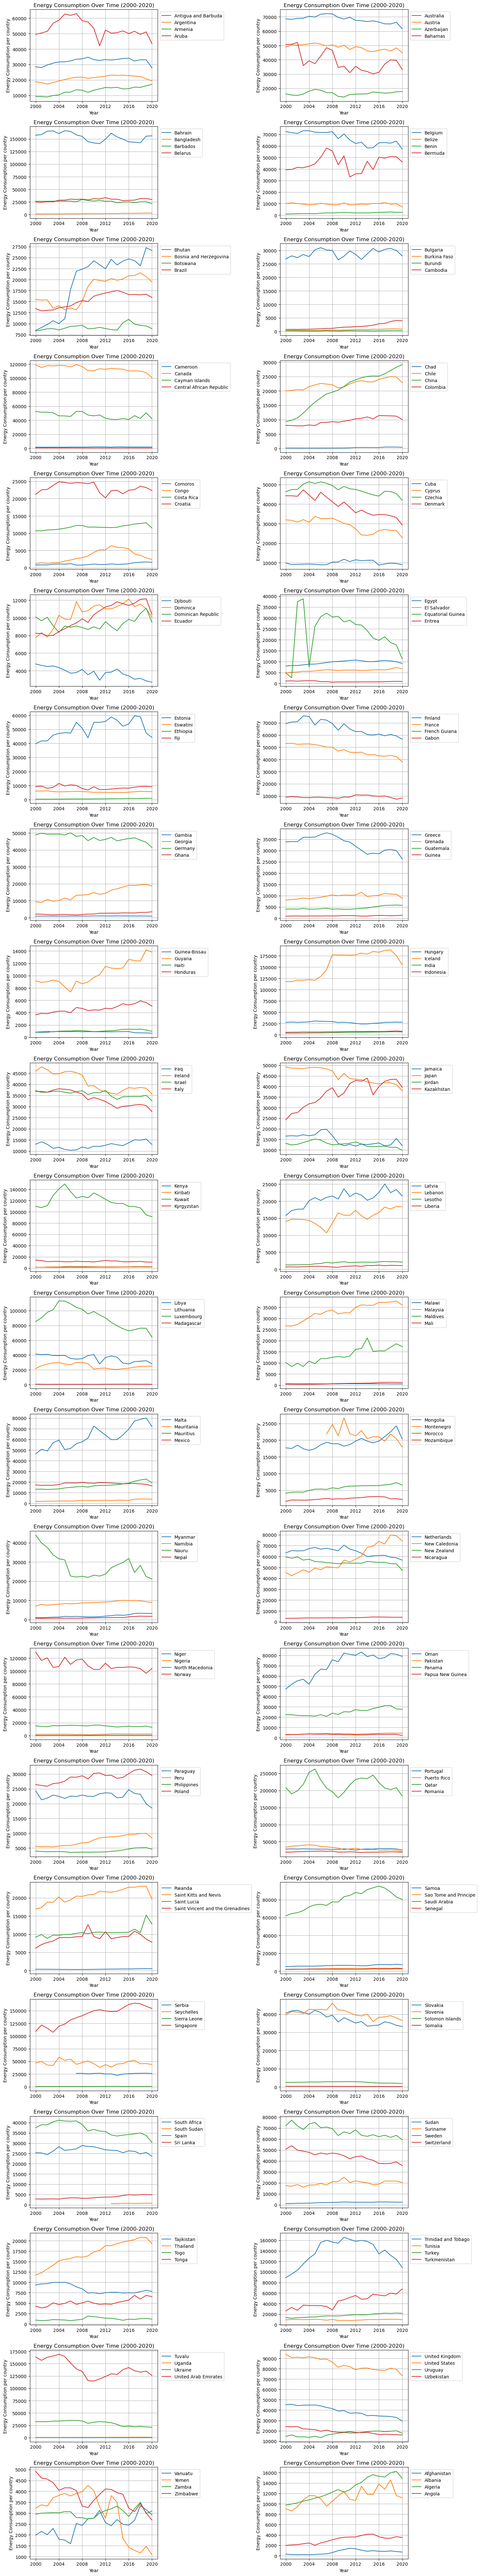

CPU times: user 56.6 s, sys: 1.27 s, total: 57.8 s
Wall time: 59.3 s


In [15]:
%%time
# PLOTTING THE TREND OF ENERGY CONSUMPTION PER COUNTRY
# Let's slice the graphs

energy_country = filter_df[['Entity', 'TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)']]   # Enerigy consumption per country
data = data_slicing(energy_country['Entity'].unique(), 44)                                              # Passing only the countries to plot the trend afterwards (10 countries per graph)
total_graphs = len(data)                                                                                # Define the total number of graphs and the number of columns
num_columns = 2                                                                                         # Defining the nnumber of columns
num_rows = (total_graphs + num_columns - 1) // num_columns                                              # Calculate the number of rows needed
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15,80))                                        # Create the subplot grid
axes = axes.flatten()                                                                                   # Flatten the axes array for easier iteration (2D)

# Iterate over each graph and plot it in the corresponding subplot
for i, c in enumerate(data):
    ax = axes[i]
    drawing(c, energy_country)
    plt.sca(ax)                                                                                         # Set the current axis to the current subplot

# Hide any unused subplots
for ax in axes[total_graphs:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# need the same thing for the Co2

As we can see in the plots, there are some marked trends and seasonalities that makes the Time series not to be stationary. It is recommendable to work with stationaries Time series. On the other hand, we need to use a more robust way of checking the stationarity of a Time series. For this, we are going to uuse the test ***Augmented Dickey-Fuller test (ADF Test)***.

Without entering in details on the math considerations, we need to have 2 things into consideration:
    
    1. The ADF Statistics.
    2. The p_value which in turn has to be less than 0.05 (5%).

# VERIFYING THE STATIONARITY OF THE TIME SERIES:

Since we have two variables, then, I will run the test for the targets only (those are the ones I want to calculate) Co2 and Energy consumption per country.

In [16]:
# ENERGY:
ad_fuller_EC = adfuller(filter_df['TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)'])
print("ADF test for TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON):\n")
print(f"\t1. ADF Statistic: {ad_fuller_EC[0]}")
print(f'\t2. P-value: {ad_fuller_EC[1]}\n')

# CO2:
ad_fuller_CO2 = adfuller(filter_df['TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY'])
print("ADF test for TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY:\n")
print(f"\t1. ADF Statistic: {ad_fuller_CO2[0]}")
print(f'\t2. P-value: {ad_fuller_CO2[1]}\n')

ADF test for TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON):

	1. ADF Statistic: -8.818521275007052
	2. P-value: 1.905105757930463e-14

ADF test for TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY:

	1. ADF Statistic: -8.416674022512328
	2. P-value: 2.0349020500263425e-13



As we can see here, the test is showing us a p-value greater than 0.05 in both cases, which means the series is not stationary.
Let's try to make it stationary.

In [17]:
# IN THIS CASE, WE ARE GOING TO USE .diff BUT LATER ON, WE CAN CHECK WHAT ELSE WE CAN USE.

# ENERGY:
ad_fuller_EC = adfuller(filter_df['TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)'].diff()[1:])
print("ADF test for TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON):\n")
print(f"\t1. ADF Statistic: {ad_fuller_EC[0]}")
print(f'\t2. P-value: {ad_fuller_EC[1]}\n')

# CO2:
ad_fuller_CO2 = adfuller(filter_df['TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY'].diff()[1:])
print("ADF test for TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY:\n")
print(f"\t1. ADF Statistic: {ad_fuller_CO2[0]}")
print(f'\t2. P-value: {ad_fuller_CO2[1]}\n')

ADF test for TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON):

	1. ADF Statistic: -21.497388264264984
	2. P-value: 0.0

ADF test for TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY:

	1. ADF Statistic: -19.86464286711195
	2. P-value: 0.0



Now, we can see that the series are stationary for the energy consumption.

Another aspect to have in mind is to check if the series are correlating to each other. To check this information, we are going to make use of the granger Casualty test. The test works like this:

*"The data for testing whether the time series in the second column Granger causes the time series in the first column. (Missing values are not supported that is why we cleaned the data frame)".*

Source:

    a. https://www.machinelearningplus.com/time-series/granger-causality-test-in-python/
    b. https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html

To interpret the test, we should take a look at he P values given. It should be again, less than 0.05

In [18]:
# PRINTING ENERGY VS CO2:
print("Energy consumption causes Carbon emissions:\n")
grangerEnergy_Co2 = grangercausalitytests(filter_df[['TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)', 
                                                    'TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY']], maxlag=5)

Energy consumption causes Carbon emissions:


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5745  , p=0.4485  , df_denom=3645, df_num=1
ssr based chi2 test:   chi2=0.5750  , p=0.4483  , df=1
likelihood ratio test: chi2=0.5749  , p=0.4483  , df=1
parameter F test:         F=0.5745  , p=0.4485  , df_denom=3645, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3867  , p=0.6793  , df_denom=3642, df_num=2
ssr based chi2 test:   chi2=0.7745  , p=0.6789  , df=2
likelihood ratio test: chi2=0.7744  , p=0.6790  , df=2
parameter F test:         F=0.3867  , p=0.6793  , df_denom=3642, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2684  , p=0.8482  , df_denom=3639, df_num=3
ssr based chi2 test:   chi2=0.8067  , p=0.8479  , df=3
likelihood ratio test: chi2=0.8066  , p=0.8479  , df=3
parameter F test:         F=0.2684  , p=0.8482  , df_denom=3639, df_num=3

Granger Causality
number of lags (no zero)

In [19]:
# PRINTING CO2 VS ENERGY:
print("Carbon emissions causes Energy consumption:\n")
grangerCo2_Energy = grangercausalitytests(filter_df[['TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY',
                                                    'TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)']], maxlag=5)

Carbon emissions causes Energy consumption:


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0538  , p=0.8166  , df_denom=3645, df_num=1
ssr based chi2 test:   chi2=0.0538  , p=0.8165  , df=1
likelihood ratio test: chi2=0.0538  , p=0.8165  , df=1
parameter F test:         F=0.0538  , p=0.8166  , df_denom=3645, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0382  , p=0.9626  , df_denom=3642, df_num=2
ssr based chi2 test:   chi2=0.0764  , p=0.9625  , df=2
likelihood ratio test: chi2=0.0764  , p=0.9625  , df=2
parameter F test:         F=0.0382  , p=0.9626  , df_denom=3642, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0482  , p=0.9860  , df_denom=3639, df_num=3
ssr based chi2 test:   chi2=0.1450  , p=0.9859  , df=3
likelihood ratio test: chi2=0.1450  , p=0.9859  , df=3
parameter F test:         F=0.0482  , p=0.9860  , df_denom=3639, df_num=3

Granger Causality
number of lags (no zero)

# SPLITTING THE DATA INTO TRAIN, AND TEST:

    1. We need to extract the column we are going to work with.
    2. Splitting the data (not ramdomizing it since it is a time series)

In [20]:
final_df = filter_df[['Entity', 'TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)', 
                                                    'TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY']]
final_df.head()

,Entity,TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON),TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY
Year,,,
2000-01-01,Afghanistan,302.59482,760.000000
2001-01-01,Afghanistan,236.89185,730.000000
2002-01-01,Afghanistan,210.86215,1029.999971
2003-01-01,Afghanistan,229.96822,1220.000029
2004-01-01,Afghanistan,204.23125,1029.999971


In [21]:
final_df.shape

(3649, 3)

In [22]:
# ENCODING THE TEXT TO BE ABLE TO TRAIN THE MODEL:

# final_df_encoded = final_df.copy() # Create a copy of the DataFrame
# final_df_encoded
# encoder = LabelEncoder() # Instantiate the LabelEncoder
# entity_encoded = encoder.fit_transform(final_df['Entity']) # Encode the 'Entity' column
# final_df_encoded['Entity_encoded'] = entity_encoded
# final_df_encoded.drop('Entity', axis = 1, inplace = True)
# final_df_encoded.head()

final_df_encoded = final_df[['TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)', 
                             'TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY']]
final_df_encoded.head()

,TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON),TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY
Year,,
2000-01-01,302.59482,760.000000
2001-01-01,236.89185,730.000000
2002-01-01,210.86215,1029.999971
2003-01-01,229.96822,1220.000029
2004-01-01,204.23125,1029.999971


In [23]:
final_df_encoded.index

DatetimeIndex(['2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01',
               ...
               '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01',
               '2019-01-01', '2020-01-01'],
              dtype='datetime64[ns]', name='Year', length=3649, freq=None)

In [24]:
# SPLITTING THE DATA:
train_df = final_df_encoded[:-730]
test_df = final_df_encoded[-730:]                # 20% for testing

In [25]:
train_df.shape, test_df.shape

((2919, 2), (730, 2))

# TRAINING THE MODEL:

In [26]:
model = VAR(train_df.diff()[1:])
sorted_order = model.select_order(maxlags=20)
sorted_order.summary()

/Users/alberto/Desktop/PROJECTS/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alberto/Desktop/PROJECTS/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,43.17*,43.18*,5.630e+18*,43.18*
1,43.17,43.19,5.631e+18,43.18
2,43.18,43.20,5.644e+18,43.18
3,43.18,43.21,5.659e+18,43.19
4,43.18,43.22,5.669e+18,43.19
5,43.18,43.23,5.678e+18,43.20
6,43.18,43.24,5.677e+18,43.20
7,43.18,43.25,5.688e+18,43.21
8,43.19,43.26,5.703e+18,43.21
9,43.19,43.27,5.709e+18,43.22


Minimum lags found at the 20th. That is the one we are going to be using in the model

In [27]:
%%time
var_model = VARMAX(train_df, order=(1, 0), enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
fitted_model.summary()

/Users/alberto/Desktop/PROJECTS/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alberto/Desktop/PROJECTS/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alberto/Desktop/PROJECTS/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


CPU times: user 1.56 s, sys: 343 ms, total: 1.9 s
Wall time: 974 ms


Dep. Variable:,"['TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)', 'TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY']",No. Observations:,2919
Model:,VAR(1),Log Likelihood,-71203.781
,+ intercept,AIC,142425.562
Date:,"Wed, 27 Mar 2024",BIC,142479.373
Time:,18:37:15,HQIC,142444.945
Sample:,0,,
,- 2919,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"5.59, 1.00",Jarque-Bera (JB):,"2347199.29, 324678762.23"
Prob(Q):,"0.02, 0.32",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"1.70, 0.01",Skew:,"0.81, -33.67"


# MAKING PREDICTIONS:

In [28]:
n_forecast = 5
predict = fitted_model.get_prediction(start = len(train_df), end = len(train_df) + n_forecast)
predictions = predict.predicted_mean

/Users/alberto/Desktop/PROJECTS/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alberto/Desktop/PROJECTS/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [29]:
predictions.columns = [['TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON)',
       'TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY']]
predictions

,TARGET_1_PRIMARY_ENERGY_CONSUMPTION_PER_CAPITA_(KWH/PERSON),TARGET_2_VALUE_CO2_EMISSIONS_PER_COUNTRY
2919,25137.304937,50637.359958
2920,25117.386060,55219.895015
2921,25097.709066,59552.069268
2922,25078.298382,63647.556212
2923,25059.175430,67519.282770
2924,25040.358862,71179.470045
